## 3. Cluster Analysis

### 3.1 Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import date
import holidays

In [2]:
filepath = 'data/'

In [3]:
trip_data = pd.read_pickle(filepath+'trip_data.pkl')
weather_data = pd.read_pickle(filepath+'weather_data.pkl')
station_data = pd.read_pickle(filepath+'station_data.pkl')
#geo_data = pd.read_pickle(filepath+'geo_data.pkl')

### 3.2 Data Prep for Clustering

#### 3.2.1 Feature Engineering

In [4]:
#keep features that are relevant for clustering
features = ['month', 'weekday', 'start_hour', 'user_type', 'duration']
data = trip_data[features].copy()

In [5]:
#convert user_type to binary: [0: subscriber; 1: customer]
data.loc[(data['user_type'] == 'Subscriber', 'user_type')] = 0
data.loc[(data['user_type'] == 'Customer', 'user_type')] = 1
data = data.astype({'user_type': float})

#### 3.2.2 Scaling

In [6]:
def run_scaling(df):
    """
    Method to standardize scales of all features.
    Input: df
    Output: df_scaled
    """
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns = df.columns, index = df.index)
    return df_scaled

In [7]:
data_scaled = run_scaling(data)

#### 3.2.3 Cluster Functions

In [8]:
def grid_search(df_scaled, kmax):
    """
    Method to run grid search.
    Input: df_scaled, kmax
    Returns: clusters (type:list);
        losses (type:list)"""
    k_max = kmax

    clusters = []
    losses = []
    #perform grid search / iterate through k
    for k in range(k_max):
        model = KMeans(n_clusters = k + 1)
        model.fit(df_scaled)
        clusters.append(k+1)
        losses.append(model.inertia_)
    
    #plot results
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.show()
    
    return clusters, losses

In [9]:
# find the "elbow" in the graph for optimal n of clusters
def find_elbow(clusters, losses, start, end):
    """
    Method to zoom in on a graph to find the elbow.
    Input: clusters (list), losses (list), start (int), end (int)
    Returns: None"""
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([start,end])
    plt.plot(clusters, losses)

In [10]:
def run_kmeans(df, df_scaled, k, re):
    """
    Method to run k_means algorithm
    Inputs:
        1. df: original (unscaled) dataframe
        2. df_scaled
        3. k (int)
        4. re: 'orig' or 'scaled' dataframe to return
    Returns: df"""
    #fit algorithm
    model = KMeans(n_clusters=k)
    model.fit(df_scaled)

    #match clusters to trip data
    if re == 'scaled':
        df_scaled['cluster'] = model.predict(df_scaled)
        df = df_scaled
    elif re == 'orig':
        df['cluster'] = model.predict(df_scaled)
    else:
        print("enter 'orig' or 'scaled' as return parameter")

    return df

In [52]:
def visualize_clusters(df, f):
    """
    Method to visualize clusters
    Input: df, f (list of features)
    Returns: None
    """
    n_rows = 3
    n_cols = 2
    violin_plt, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (18, 12))
    
    #create violins
    sns.violinplot(ax=axes[0,0], x='cluster', y=f[0], data=df)
    sns.violinplot(ax=axes[0,1], x='cluster', y=f[1], data=df)
    sns.violinplot(ax=axes[1,0], x='cluster', y=f[2], data=df)
    sns.violinplot(ax=axes[1,1], x='cluster', y=f[3], data=df)
    sns.violinplot(ax=axes[2,0], x='cluster', y=f[4], data=df)
    
    #add barplot to show the size of each cluster
    cluster_counts = df.groupby(['cluster'], as_index=False).agg({'cluster':'count'})
    axes[2,1].pie(cluster_counts['cluster'], labels=cluster_counts.index.tolist(), autopct='%1.1f%%',shadow=True, startangle=90)
    axes[2,1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axes[2,1].set_title('distribution of cluster sizes', fontsize=18)
    
    #set titles to column/feature name
    axes[0,0].set_title(f[0], fontsize=16)
    axes[0,1].set_title(f[1], fontsize=16)
    axes[1,0].set_title(f[2], fontsize=16)
    axes[1,1].set_title(f[3], fontsize=16)
    axes[2,0].set_title(f[4], fontsize=16)
    axes[2,1].set_title('distribution of cluster sizes', fontsize=16)
    
    #set tight layout so titles do not overlap x-axes
    violin_plt.tight_layout()
    
    plt.show()

### 3.3 Cluster trips to identify trip/customer types

First we cluster trips to identify trip and customer types. Because the data lacks customer ids we can only  Important features from our trip data are the time and duration of rental and the user type. This way we can only infer the customer type from the trip type by showing patterns of usage.<br> We proceed by first finding the optimal number of clusters ('k') using grid search. We explore the elbow of the graph (trade-off between loss and number of clusters) and try different values in the optimality range by inserting them in the k-means algorithm. We evaluate optimality of different k-values from our previous insights from descriptive analytics of the data.

#### 3.3.1 Use grid search to determine optimal n of clusters

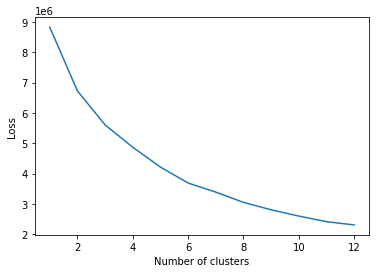

In [12]:
clu, los = grid_search(data_scaled, 12)

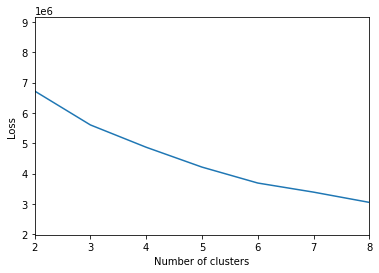

In [13]:
find_elbow(clu, los, 2, 8)

The interval of about [3,6] looks ideal.

#### 3.3.2 Use optimal n of clusters for k-means clustering

In [14]:
#trip_three_means = run_kmeans(data, data_scaled, 3)
trip_four_means = run_kmeans(data, data_scaled, 4, re='orig')
#trip_five_means = run_kmeans(data, data_scaled, 5)
#trip_six_means = run_kmeans(data, data_scaled, 6)

#### 3.3.3 Visualize the data to evaluate k

We use violin plots as they show how our quantitative data is distributed across our different categorical variables.

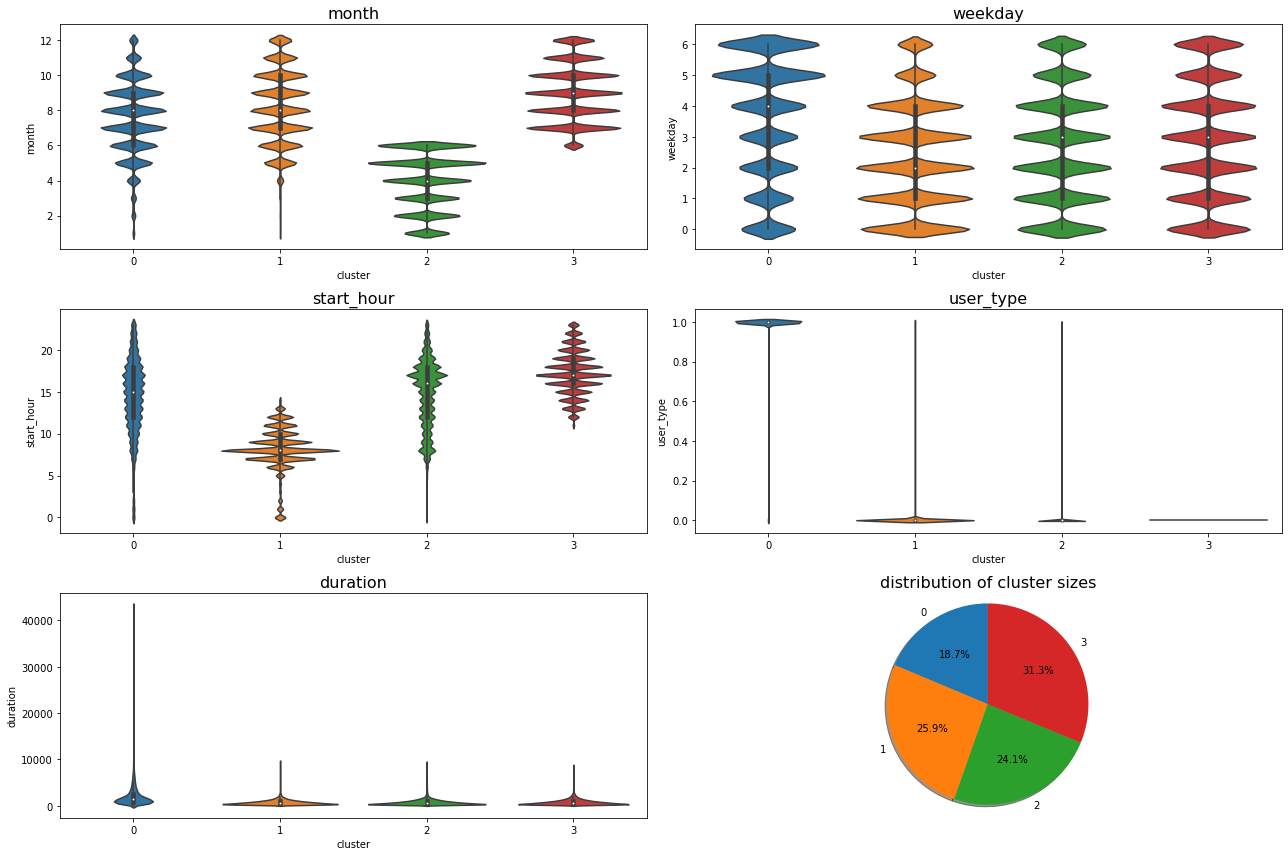

In [53]:
visualize_clusters(trip_four_means, features)

### 3.4 Cluster Locations (based on their demand pattern)

We cluster locations (stations) based on their demand patterns, i.e. commuter flows. Our observation level is therefore weekdays (Monday to Friday) on which there is no public holiday. Again, we first do grid search to find the optimal number of clusters, and then do k-means to cluster the stations.

demand patterns will show that some stations are:
- more likely start stations in the morning / end stations in the evening (residential areas)
- other way round for work areas
- no substantial differences for mixed areas
- some stations are less frequented on weekends (work/university areas)
- more frequented at weekends (leisure areas)
- no substantial differences for mixed areas

#### 3.4.1 Prepare the data

Add holiday feature:

In [16]:
#create dict with holidays
ma_holidays = holidays.country_holidays('US', subdiv='MA')

#add binary variable if date is public holiday
trip_data['is_holiday'] = trip_data['start_time'].apply(lambda x: 1 if x in ma_holidays else 0)

In [17]:
#create df with trips made exclusively on workdays
workday_trips = trip_data.loc[(trip_data['weekday'] < 5) & (trip_data['is_holiday'] == 0)].copy()

In [18]:
# create new dfs with number of trips for each hour (aggregated on workdays)
wd_stack = workday_trips.groupby(['start_hour','start_station_id']).count()

In [51]:
def unstack_n_fill(df):
    # unstack
    df = df['bike_id'].unstack()
    # transpose
    df = df.transpose(copy=True)
    # fill nan values
    df = df.fillna(0)
    return df

In [20]:
wd_unstacked = unstack_n_fill(wd_stack)

In [21]:
#scale the data
wd_scaled = run_scaling(wd_unstacked)

#### 3.4.2 Use grid search to determine optimal n of clusters

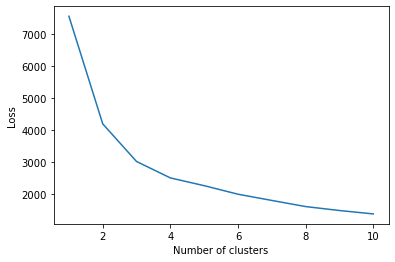

In [22]:
cl_wd, los_wd = grid_search(wd_scaled, 10)

Elbow seems to be at [2,4]

#### 3.4.3 Run k-means

In [48]:
station_three_means = run_kmeans(wd_unstacked, wd_scaled, 3, re='orig')

#### 3.4.4 Plot the clusters

In [49]:
def run_station_plots(df):
    k = df['cluster'].nunique()
    
    fig, axes = plt.subplots(nrows = 2, ncols = k, figsize=(20,20))
    
    top_ylim_global = 0
    
    for c in range(0, k):
        df_sub = df.loc[(df['cluster']==c)].copy()
        df_sub.drop(columns='cluster', inplace=True)
        df_sub = df_sub.transpose()
        df_sub.plot(ax=axes[0,c],alpha=0.1)
        #print(df_sub)
        #sns.barplot(ax=axes[0,c], x=df_sub.columns, y='cluster', data=df_sub)
        
        df_sub['avg'] = df_sub.mean(numeric_only=True, axis=1)
        df_sub['avg'].plot(ax=axes[0,c], color='green')
        
        axes[0,c].get_legend().remove()
        axes[0,c].set_title('Cluster '+str(c))
        axes[0,c].set_xlabel('start_hour')
        axes[0,c].set_ylabel('Sum of Trips')
        
        #get highest y_lim so all axes are on the same scale
        bottom, top = axes[0,c].get_ylim()
        if top > top_ylim_global:
            top_ylim_global = top
        
    for c in range(0, k): 
        axes[0,c].set_ylim(top=top_ylim_global)
        
    #add pieplot to show the distribution of cluster sizes
    cluster_counts = df.groupby(['cluster'], as_index=False).agg({'cluster':'count'})
    axes[1,1].pie(cluster_counts['cluster'], labels=cluster_counts.index.tolist(), autopct='%1.1f%%',shadow=True, startangle=90)
    axes[1,1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axes[1, 1].set_title('distribution of cluster sizes', fontsize=18)
    


    plt.show()

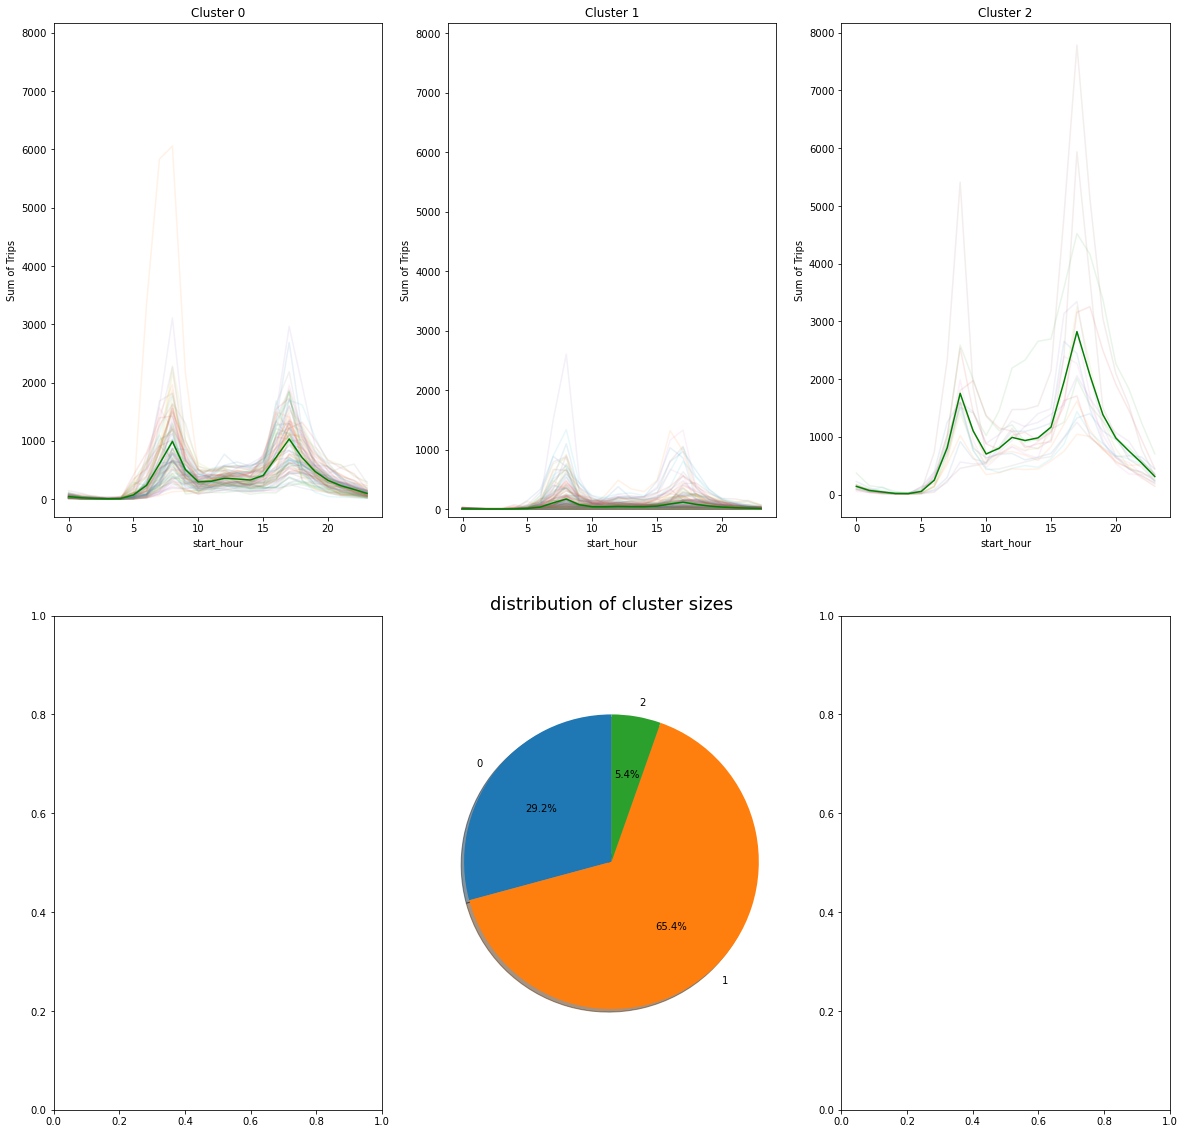

In [50]:
run_station_plots(station_three_means)

After having plotted k=2, 3 and 4 clusters, we stick to 3 clusters. While the clusters with k=2 are not granular enough, the clusters with k=4 become relatively small. Even with k=3 we already see that cluster 2 contains only 5.4% of all stations.